In [3]:
import numpy as np
import skimage.io
import skimage.color
from skimage.transform import downscale_local_mean
import numpy as np
import cupy as cp
from skimage.restoration import estimate_sigma
from skimage.metrics import peak_signal_noise_ratio, structural_similarity
from numba import njit

def add_salt_and_pepper_noise(image, salt_prob=0.01, pepper_prob=0.01):   
    """
    Adds salt and pepper noise to an image.

    Parameters:
    - image: input image (numpy array).
    - salt_prob: probability of salt pixels (white).
    - pepper_prob: probability of pepper pixels (black).

    Returns:
    - Image with salt and pepper noise.
    """
    
    row, col = image.shape
    noisy = np.copy(image)

    # Adds salt noise
    salt_pixels = np.random.rand(row, col) < salt_prob
    noisy[salt_pixels] = 255

    # Adds pepper noise
    pepper_pixels = np.random.rand(row, col) < pepper_prob
    noisy[pepper_pixels] = 0

    return noisy.astype(np.uint8)

def add_noise_gaussian(img):
    m, n = img.shape
    sigma = 10
    noise = np.random.normal(0, sigma, (m, n)).astype(np.float32)
    noised = np.clip(img + noise, 0, 255)
    return noised

def add_poisson_noise(img):    
    poisson_img = np.random.poisson(img)    
    return poisson_img

def add_poisson_gaussian_noise(image, gaussian_sigma=25):
    # Apply Poisson noise
    poisson_image = np.random.poisson(image)

    # Apply Gaussian noise
    gaussian_noise = np.random.normal(loc=0.0, scale=gaussian_sigma, size=image.shape)
    noisy_image = poisson_image + gaussian_noise 

    noisy_image = np.clip(noisy_image, 0, 255).astype(np.uint8)
    
    return noisy_image

def downscale(img):
    img_downscale = downscale_local_mean(img, (2, 2)).astype(np.float32)
    return img_downscale

def anscombe_transform(img):
    return 2.0 * np.sqrt(img.astype(np.float32) + 3.0 / 8.0)

def inverse_anscombe(y):
    # Inversa exata de Makitalo & Foi (IEEE T-IP 2011)
    return ((y / 2.0)**2) - 3.0 / 8.0

def compute_adaptive_q(sigma_est, anscombe=False):
    q_nlm = 0.8 + 0.5 * np.tanh(0.3 * (sigma_est - 1))
    q_geo = 1.0 + 0.7 * np.tanh(0.25 * (sigma_est - 1.5))

    if anscombe:
        q_nlm = int(np.clip(q_nlm, 0.7, 2.2) * 10)
        q_geo = int(np.clip(q_geo, 0.9, 2.7) * 10)
    else:
        q_nlm = int(np.clip(q_nlm, 0.7, 2.2) * 100)
        q_geo = int(np.clip(q_geo, 0.9, 2.7) * 100)

    print(f'q_nlm: {q_nlm}, g_geo: {q_geo}')
    return q_nlm, q_geo





In [4]:
import numpy as np
import skimage.io
import skimage.color
from skimage.restoration import estimate_sigma
from skimage.transform import downscale_local_mean
from skimage.metrics import peak_signal_noise_ratio, structural_similarity
import matplotlib.pyplot as plt
from joblib import Parallel, delayed

# Assuma que essas funções estão definidas:
# - downscale
# - mirror_cpu
# - add_noise_gaussian
# - compute_adaptive_q
# - Parallel_GEONLM (otimizada)
# - process_pixel (otimizada)

def run_geonlm_pipeline(img_original, img_noisy, f, t, h_base, nn=10, h_multipliers=[0.70,0.80,0.90,1.1,1.15,1.20,1.25,1.30,1.35]):#, 1.05, 1.10, 1.15, 1.2, 1.23, 1.25,1.35]):
    melhor_score = -np.inf
    melhor_img = None
    melhor_h = None
    melhor_psnr = None
    melhor_ssim = None

    for mult in h_multipliers:
        h_geo = h_base * mult
        print(f"\nExecutando GEONLM com h = {h_geo:.2f} (base {h_base} * {mult})")

        img_geo = Parallel_GEONLM(img_noisy, f=f, t=t, h=h_geo, nn=nn)

        img_ref = np.clip(img_original, 0, 255).astype(np.uint8)
        img_geo_uint8 = np.clip(img_geo, 0, 255).astype(np.uint8)

        psnr = peak_signal_noise_ratio(img_ref, img_geo_uint8, data_range=255)
        ssim = structural_similarity(img_ref, img_geo_uint8, data_range=255)

        score = 0.5 * psnr + 0.5 * (ssim * 100)
        print(f"→ PSNR: {psnr:.2f}, SSIM: {ssim:.4f}, Score: {score:.2f}")

        if score > melhor_score:
            melhor_score = score
            melhor_img = img_geo
            melhor_h = h_geo
            melhor_psnr = psnr
            melhor_ssim = ssim

    print(f"\n[FINAL] Melhor h: {melhor_h}, PSNR: {melhor_psnr:.2f}, SSIM: {melhor_ssim:.4f}, SCORE: {melhor_score:.4f} ")
    return melhor_img, melhor_h, melhor_psnr, melhor_ssim, melhor_score


# ------------------------- FUNÇÕES AUXILIARES -------------------------

def downscale_to_64(img):
    factor_h = img.shape[0] // 64
    factor_w = img.shape[1] // 64
    return downscale_local_mean(img, (factor_h, factor_w)).astype(np.float32)

def crop_center(img, size=(64, 64)):
    h, w = img.shape
    ch, cw = size
    start_h = h // 2 - ch // 2
    start_w = w // 2 - cw // 2
    return img[start_h:start_h+ch, start_w:start_w+cw].astype(np.float32)

def run_single_pipeline(img_base, f, t, nn):
    img_noisy = add_salt_and_pepper_noise(img_base)
    sigma = estimate_sigma(img_noisy)
    h_nlm, _ = compute_adaptive_q(sigma)
    img_noisy_mirror = mirror_cpu(img_noisy, f)

    melhor_img, melhor_h, melhor_psnr, melhor_ssim, melhor_score = run_geonlm_pipeline(
        img_original=img_base,
        img_noisy=img_noisy_mirror,
        f=f, t=t,
        h_base=h_nlm,
        nn=nn
    )
    return img_base, img_noisy, melhor_img, melhor_h, melhor_psnr, melhor_ssim

@njit
def mirror_cpu(A, f):
    n, m = A.shape
    nlin = n + 2*f
    ncol = m + 2*f
    B = np.zeros((nlin, ncol), dtype=A.dtype)

    B[f:n+f, f:m+f] = A
    B[0:f, f:m+f] = A[0:f, :][::-1, :]
    B[n+f:, f:m+f] = A[n-f:, :][::-1, :]
    B[f:n+f, 0:f] = A[:, 0:f][:, ::-1]
    B[f:n+f, m+f:] = A[:, m-f:][:, ::-1]
    B[0:f, 0:f] = A[0:f, 0:f][::-1, ::-1]
    B[0:f, m+f:] = A[0:f, m-f:][::-1, ::-1]
    B[n+f:, 0:f] = A[n-f:, 0:f][::-1, ::-1]
    B[n+f:, m+f:] = A[n-f:, m-f:][::-1, ::-1]

    return B

from joblib import Parallel, delayed

def Parallel_GEONLM(img_n, f, t, h, nn):
    print(f'img_n.shape: {img_n.shape}')
    m = img_n.shape[0] - 2 * f
    n = img_n.shape[1] - 2 * f
    print(f'M: {m}, N: {n}')

    filtrada = Parallel(n_jobs=-1)(
        delayed(process_pixel)(i, j, img_n, f, t, h, nn, m, n)
        for i in range(m)
        for j in range(n)
    )

    filtrada_geo = np.array(filtrada).reshape((m, n))
    return filtrada_geo

import sklearn.neighbors as sknn
import networkx as nx

def process_pixel(i, j, img_n, f, t, h, nn, m, n):
    im = i + f
    jn = j + f
    patch_central = img_n[im - f:im + f + 1, jn - f:jn + f + 1]
    central = patch_central.ravel()

    rmin = max(im - t, f)
    rmax = min(im + t, m + f)
    smin = max(jn - t, f)
    smax = min(jn + t, n + f)

    n_patches = (rmax - rmin) * (smax - smin)
    patch_size = (2 * f + 1) ** 2

    dataset = np.empty((n_patches, patch_size), dtype=np.float32)
    pixels_busca = np.empty(n_patches, dtype=np.float32)

    source = -1
    k = 0
    for r in range(rmin, rmax):
        for s in range(smin, smax):
            W = img_n[r - f:r + f + 1, s - f:s + f + 1]
            neighbor = W.ravel()
            dataset[k, :] = neighbor
            pixels_busca[k] = img_n[r, s]
            if np.array_equal(central, neighbor):
                source = k
            k += 1

    if source == -1:
        source = 0  # fallback para evitar erro

    knnGraph = sknn.kneighbors_graph(dataset, n_neighbors=nn, mode='distance')
    G = nx.from_scipy_sparse_array(knnGraph)
    length, _ = nx.single_source_dijkstra(G, source)

    points = list(length.keys())
    distancias = np.array(list(length.values()), dtype=np.float32)

    similaridades = np.exp(-distancias ** 2 / (h ** 2))
    pixels = pixels_busca[points]

    NL = np.sum(similaridades * pixels)
    Z = np.sum(similaridades)
    return NL / Z if Z > 0 else img_n[im, jn]

### NEW

In [9]:
def run_geonlm_pipelineNEW(img_original, img_noisy, f, t, h_base, nn=10, h_multipliers=[0.70,0.80,0.90,1.1,1.15,1.20,1.25,1.30,1.35]):#, 1.05, 1.10, 1.15, 1.2, 1.23, 1.25,1.35]):
    melhor_score = -np.inf
    melhor_img = None
    melhor_h = None
    melhor_psnr = None
    melhor_ssim = None

    for mult in h_multipliers:
        h_geo = h_base * mult
        print(f"\nExecutando GEONLM com h = {h_geo:.2f} (base {h_base} * {mult})")

        img_geo = Parallel_GEONLM(img_noisy, f=f, t=t, h=h_geo, nn=nn)

        img_ref = np.clip(img_original, 0, 255).astype(np.uint8)
        img_geo_uint8 = np.clip(img_geo, 0, 255).astype(np.uint8)

        psnr = peak_signal_noise_ratio(img_ref, img_geo_uint8, data_range=255)
        ssim = structural_similarity(img_ref, img_geo_uint8, data_range=255)

        score = 0.5 * psnr + 0.5 * (ssim * 100)
        print(f"→ PSNR: {psnr:.2f}, SSIM: {ssim:.4f}, Score: {score:.2f}")

        if score > melhor_score:
            melhor_score = score
            melhor_img = img_geo
            melhor_h = h_geo
            melhor_psnr = psnr
            melhor_ssim = ssim

    print(f"\n[FINAL] Melhor h: {melhor_h}, PSNR: {melhor_psnr:.2f}, SSIM: {melhor_ssim:.4f}, SCORE: {melhor_score:.4f} ")
    return melhor_img, melhor_h, melhor_psnr, melhor_ssim, melhor_score



# ------------------------- EXEMPLO DE USO COM 3 ABORDAGENS -------------------------

# Parâmetros
f = 4
t = 7
nn = 10

# Carregamento
img_path = '../images/0.gif'
img = skimage.io.imread(img_path)
img = img[0, :, :] if len(img.shape) > 2 else img
if len(img.shape) > 2:
    img = skimage.color.rgb2gray(img)
    img = 255 * img
img = img.astype(np.float32)

# Abordagens
downscale_x4 = downscale_local_mean(img, (4, 4)).astype(np.float32)
downscale_64x64 = downscale_to_64(img)

img_noisy = add_noise_gaussian(downscale_x4)
sigma = estimate_sigma(img_noisy)
h_nlm, _ = compute_adaptive_q(sigma)
img_noisy_mirror = mirror_cpu(img_noisy, f)

   

# Chamada ao pipeline, agora passando a imagem original e a imagem ruidosa
img_base, img_noisy, img_filtered, h_val, psnr_val, ssim_val, score_val = run_geonlm_pipelineNEW(
    downscale_x4, img_noisy, f, t, h_nlm, nn
)
   

# # ------------------------- VISUALIZAÇÃO -------------------------

# import matplotlib.pyplot as plt

# # Exibindo os resultados de cada abordagem
# for label, (original, noisy, filtered, h, psnr, ssim) in results.items():
#     plt.figure(figsize=(12, 3))
#     plt.suptitle(f"{label} | h={h} | PSNR={psnr:.2f} | SSIM={ssim:.4f}")
    
#     # Exibindo as imagens de forma organizada
#     plt.subplot(1, 3, 1); plt.title("Original"); plt.imshow(original.astype(np.uint8), cmap='gray'); plt.axis('off')
#     plt.subplot(1, 3, 2); plt.title("Ruidosa"); plt.imshow(noisy.astype(np.uint8), cmap='gray'); plt.axis('off')
#     plt.subplot(1, 3, 3); plt.title("GEONLM"); plt.imshow(filtered.astype(np.uint8), cmap='gray'); plt.axis('off')
    
#     plt.tight_layout()
#     plt.show()

q_nlm: 129, g_geo: 169

Executando GEONLM com h = 90.30 (base 129 * 0.7)
img_n.shape: (128, 128)
M: 120, N: 120


ValueError: Input images must have the same dimensions.

### Outros


--- Executando Downscale x2 ---
q_nlm: 129, g_geo: 169

Executando GEONLM com h = 90.30 (base 129 * 0.7)
img_n.shape: (264, 264)
M: 256, N: 256
→ PSNR: 30.81, SSIM: 0.8888, Score: 59.84

Executando GEONLM com h = 103.20 (base 129 * 0.8)
img_n.shape: (264, 264)
M: 256, N: 256
→ PSNR: 31.79, SSIM: 0.9107, Score: 61.43

Executando GEONLM com h = 116.10 (base 129 * 0.9)
img_n.shape: (264, 264)
M: 256, N: 256
→ PSNR: 32.53, SSIM: 0.9236, Score: 62.45

Executando GEONLM com h = 141.90 (base 129 * 1.1)
img_n.shape: (264, 264)
M: 256, N: 256
→ PSNR: 33.12, SSIM: 0.9330, Score: 63.21

Executando GEONLM com h = 148.35 (base 129 * 1.15)
img_n.shape: (264, 264)
M: 256, N: 256
→ PSNR: 33.12, SSIM: 0.9332, Score: 63.22

Executando GEONLM com h = 154.80 (base 129 * 1.2)
img_n.shape: (264, 264)
M: 256, N: 256
→ PSNR: 33.08, SSIM: 0.9329, Score: 63.18

Executando GEONLM com h = 148.35 (base 129 * 1.15)
img_n.shape: (264, 264)
M: 256, N: 256
→ PSNR: 33.12, SSIM: 0.9332, Score: 63.22

[FINAL] Melhor h: 

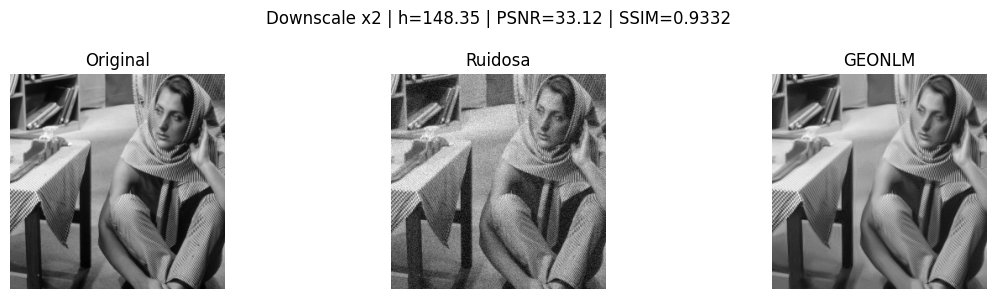

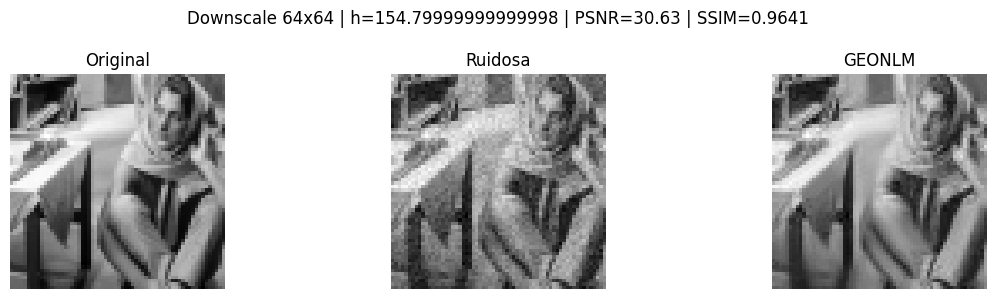

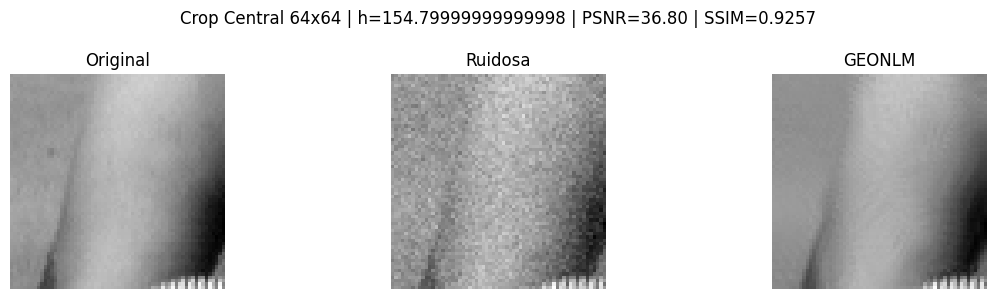

In [11]:
# ------------------------- EXEMPLO DE USO COM 3 ABORDAGENS -------------------------

# Parâmetros
f = 4
t = 7
nn = 10

# Carregamento
img_path = '../images/1.gif'
img = skimage.io.imread(img_path)
img = img[0, :, :] if len(img.shape) > 2 else img
if len(img.shape) > 2:
    img = skimage.color.rgb2gray(img)
    img = 255 * img
img = img.astype(np.float32)

# Abordagens
originals = {
    "Downscale x2": downscale_local_mean(img, (2, 2)).astype(np.float32),
    "Downscale 64x64": downscale_to_64(img),
    "Crop Central 64x64": crop_center(img, (64, 64))
}

results = {}

for label, img_variant in originals.items():
    print(f"\n--- Executando {label} ---")
    img_base, img_noisy, img_filtered, h_val, psnr_val, ssim_val = run_single_pipeline(img_variant, f, t, nn)
    results[label] = (img_base, img_noisy, img_filtered, h_val, psnr_val, ssim_val)

# ------------------------- VISUALIZAÇÃO -------------------------

import matplotlib.pyplot as plt

for label, (original, noisy, filtered, h, psnr, ssim) in results.items():
    plt.figure(figsize=(12, 3))
    plt.suptitle(f"{label} | h={h} | PSNR={psnr:.2f} | SSIM={ssim:.4f}")
    plt.subplot(1, 3, 1); plt.title("Original"); plt.imshow(original.astype(np.uint8), cmap='gray'); plt.axis('off')
    plt.subplot(1, 3, 2); plt.title("Ruidosa"); plt.imshow(noisy.astype(np.uint8), cmap='gray'); plt.axis('off')
    plt.subplot(1, 3, 3); plt.title("GEONLM"); plt.imshow(filtered.astype(np.uint8), cmap='gray'); plt.axis('off')
    plt.tight_layout()
    plt.show()


--- Executando Downscale x2 ---
q_nlm: 129, g_geo: 168

Executando GEONLM com h = 90.30 (base 129 * 0.7)
img_n.shape: (264, 264)
M: 256, N: 256
→ PSNR: 30.71, SSIM: 0.8617, Score: 58.44

Executando GEONLM com h = 103.20 (base 129 * 0.8)
img_n.shape: (264, 264)
M: 256, N: 256
→ PSNR: 31.61, SSIM: 0.8815, Score: 59.88

Executando GEONLM com h = 116.10 (base 129 * 0.9)
img_n.shape: (264, 264)
M: 256, N: 256
→ PSNR: 32.17, SSIM: 0.8901, Score: 60.59

Executando GEONLM com h = 141.90 (base 129 * 1.1)
img_n.shape: (264, 264)
M: 256, N: 256
→ PSNR: 32.31, SSIM: 0.8878, Score: 60.55

Executando GEONLM com h = 148.35 (base 129 * 1.15)
img_n.shape: (264, 264)
M: 256, N: 256
→ PSNR: 32.22, SSIM: 0.8849, Score: 60.35

Executando GEONLM com h = 154.80 (base 129 * 1.2)
img_n.shape: (264, 264)
M: 256, N: 256
→ PSNR: 32.09, SSIM: 0.8816, Score: 60.13

Executando GEONLM com h = 161.25 (base 129 * 1.25)
img_n.shape: (264, 264)
M: 256, N: 256
→ PSNR: 31.95, SSIM: 0.8779, Score: 59.87

Executando GEONLM 

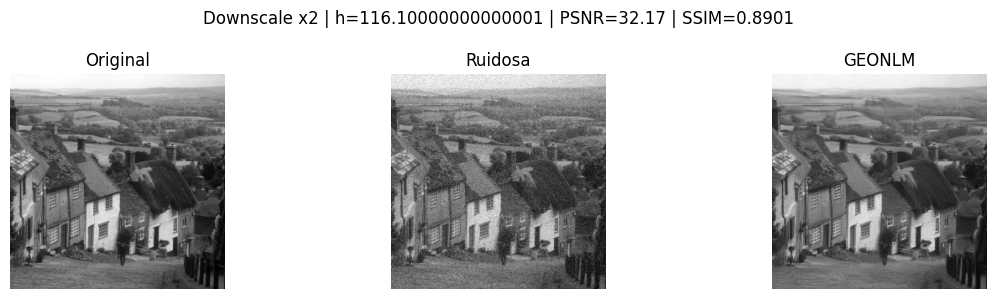

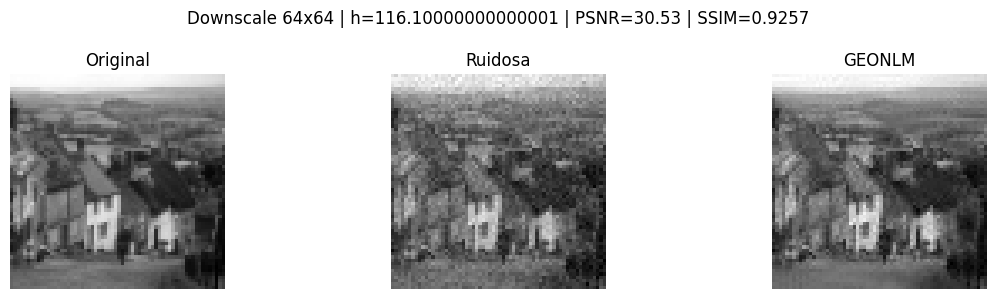

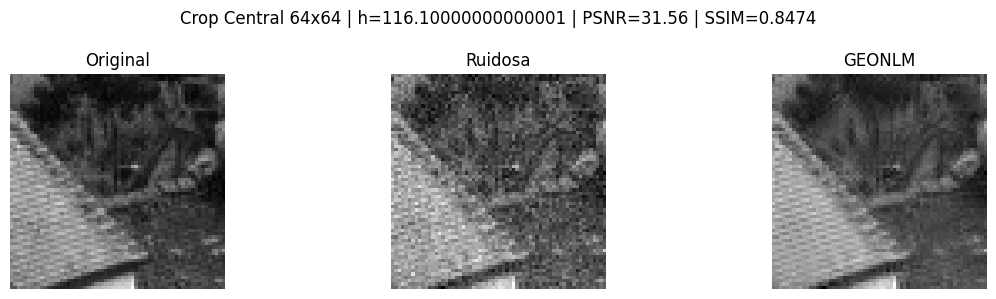

In [13]:
# ------------------------- EXEMPLO DE USO COM 3 ABORDAGENS -------------------------

# Parâmetros
f = 4
t = 7
nn = 10

# Carregamento
img_path = '../images/2.gif'
img = skimage.io.imread(img_path)
img = img[0, :, :] if len(img.shape) > 2 else img
if len(img.shape) > 2:
    img = skimage.color.rgb2gray(img)
    img = 255 * img
img = img.astype(np.float32)

# Abordagens
originals = {
    "Downscale x2": downscale_local_mean(img, (2, 2)).astype(np.float32),
    "Downscale 64x64": downscale_to_64(img),
    "Crop Central 64x64": crop_center(img, (64, 64))
}

results = {}

for label, img_variant in originals.items():
    print(f"\n--- Executando {label} ---")
    img_base, img_noisy, img_filtered, h_val, psnr_val, ssim_val = run_single_pipeline(img_variant, f, t, nn)
    results[label] = (img_base, img_noisy, img_filtered, h_val, psnr_val, ssim_val)

# ------------------------- VISUALIZAÇÃO -------------------------

import matplotlib.pyplot as plt

for label, (original, noisy, filtered, h, psnr, ssim) in results.items():
    plt.figure(figsize=(12, 3))
    plt.suptitle(f"{label} | h={h} | PSNR={psnr:.2f} | SSIM={ssim:.4f}")
    plt.subplot(1, 3, 1); plt.title("Original"); plt.imshow(original.astype(np.uint8), cmap='gray'); plt.axis('off')
    plt.subplot(1, 3, 2); plt.title("Ruidosa"); plt.imshow(noisy.astype(np.uint8), cmap='gray'); plt.axis('off')
    plt.subplot(1, 3, 3); plt.title("GEONLM"); plt.imshow(filtered.astype(np.uint8), cmap='gray'); plt.axis('off')
    plt.tight_layout()
    plt.show()


--- Executando Downscale x2 ---
q_nlm: 129, g_geo: 168

Executando GEONLM com h = 90.30 (base 129 * 0.7)
img_n.shape: (264, 264)
M: 256, N: 256
→ PSNR: 31.59, SSIM: 0.8356, Score: 57.57

Executando GEONLM com h = 103.20 (base 129 * 0.8)
img_n.shape: (264, 264)
M: 256, N: 256
→ PSNR: 32.36, SSIM: 0.8624, Score: 59.30

Executando GEONLM com h = 116.10 (base 129 * 0.9)
img_n.shape: (264, 264)
M: 256, N: 256
→ PSNR: 32.84, SSIM: 0.8782, Score: 60.33

Executando GEONLM com h = 141.90 (base 129 * 1.1)
img_n.shape: (264, 264)
M: 256, N: 256
→ PSNR: 33.02, SSIM: 0.8868, Score: 60.85

Executando GEONLM com h = 148.35 (base 129 * 1.15)
img_n.shape: (264, 264)
M: 256, N: 256
→ PSNR: 32.95, SSIM: 0.8859, Score: 60.77

Executando GEONLM com h = 154.80 (base 129 * 1.2)
img_n.shape: (264, 264)
M: 256, N: 256
→ PSNR: 32.86, SSIM: 0.8844, Score: 60.65

Executando GEONLM com h = 161.25 (base 129 * 1.25)
img_n.shape: (264, 264)
M: 256, N: 256
→ PSNR: 32.74, SSIM: 0.8821, Score: 60.48

Executando GEONLM 

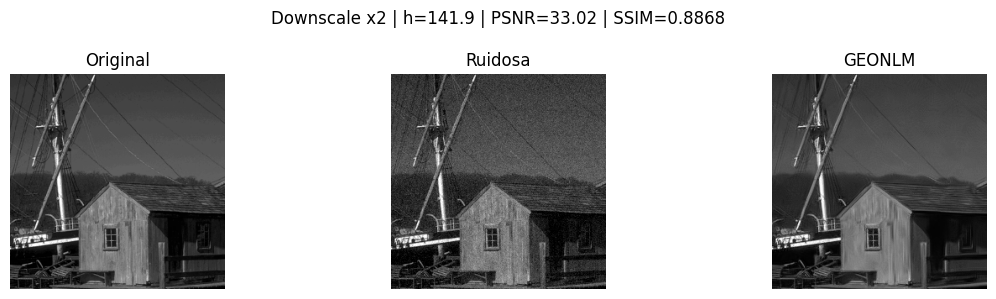

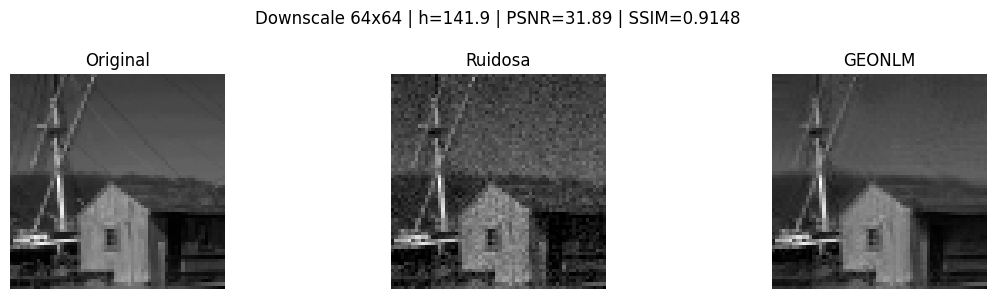

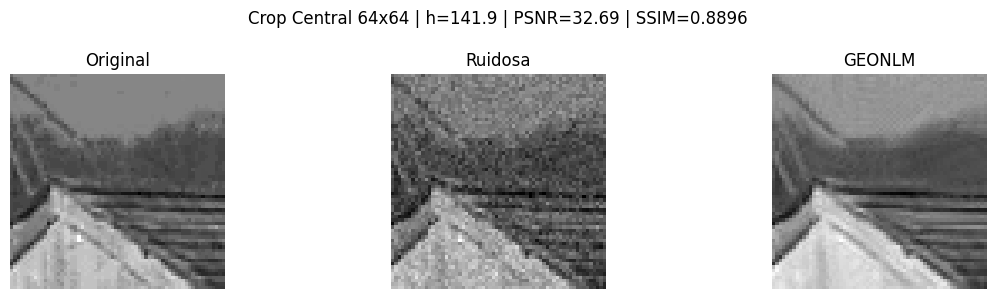

In [14]:
# ------------------------- EXEMPLO DE USO COM 3 ABORDAGENS -------------------------

# Parâmetros
f = 4
t = 7
nn = 10

# Carregamento
img_path = '../images/3.gif'
img = skimage.io.imread(img_path)
img = img[0, :, :] if len(img.shape) > 2 else img
if len(img.shape) > 2:
    img = skimage.color.rgb2gray(img)
    img = 255 * img
img = img.astype(np.float32)

# Abordagens
originals = {
    "Downscale x2": downscale_local_mean(img, (2, 2)).astype(np.float32),
    "Downscale 64x64": downscale_to_64(img),
    "Crop Central 64x64": crop_center(img, (64, 64))
}

results = {}

for label, img_variant in originals.items():
    print(f"\n--- Executando {label} ---")
    img_base, img_noisy, img_filtered, h_val, psnr_val, ssim_val = run_single_pipeline(img_variant, f, t, nn)
    results[label] = (img_base, img_noisy, img_filtered, h_val, psnr_val, ssim_val)

# ------------------------- VISUALIZAÇÃO -------------------------

import matplotlib.pyplot as plt

for label, (original, noisy, filtered, h, psnr, ssim) in results.items():
    plt.figure(figsize=(12, 3))
    plt.suptitle(f"{label} | h={h} | PSNR={psnr:.2f} | SSIM={ssim:.4f}")
    plt.subplot(1, 3, 1); plt.title("Original"); plt.imshow(original.astype(np.uint8), cmap='gray'); plt.axis('off')
    plt.subplot(1, 3, 2); plt.title("Ruidosa"); plt.imshow(noisy.astype(np.uint8), cmap='gray'); plt.axis('off')
    plt.subplot(1, 3, 3); plt.title("GEONLM"); plt.imshow(filtered.astype(np.uint8), cmap='gray'); plt.axis('off')
    plt.tight_layout()
    plt.show()


--- Executando Downscale x2 ---
q_nlm: 129, g_geo: 168

Executando GEONLM com h = 90.30 (base 129 * 0.7)
img_n.shape: (264, 264)
M: 256, N: 256
→ PSNR: 30.62, SSIM: 0.8421, Score: 57.42

Executando GEONLM com h = 103.20 (base 129 * 0.8)
img_n.shape: (264, 264)
M: 256, N: 256
→ PSNR: 31.47, SSIM: 0.8624, Score: 58.85

Executando GEONLM com h = 116.10 (base 129 * 0.9)
img_n.shape: (264, 264)
M: 256, N: 256
→ PSNR: 31.93, SSIM: 0.8700, Score: 59.47

Executando GEONLM com h = 141.90 (base 129 * 1.1)
img_n.shape: (264, 264)
M: 256, N: 256
→ PSNR: 31.81, SSIM: 0.8620, Score: 59.00

Executando GEONLM com h = 148.35 (base 129 * 1.15)
img_n.shape: (264, 264)
M: 256, N: 256
→ PSNR: 31.65, SSIM: 0.8572, Score: 58.68

Executando GEONLM com h = 154.80 (base 129 * 1.2)
img_n.shape: (264, 264)
M: 256, N: 256
→ PSNR: 31.47, SSIM: 0.8518, Score: 58.33

Executando GEONLM com h = 161.25 (base 129 * 1.25)
img_n.shape: (264, 264)
M: 256, N: 256
→ PSNR: 31.28, SSIM: 0.8460, Score: 57.94

Executando GEONLM 

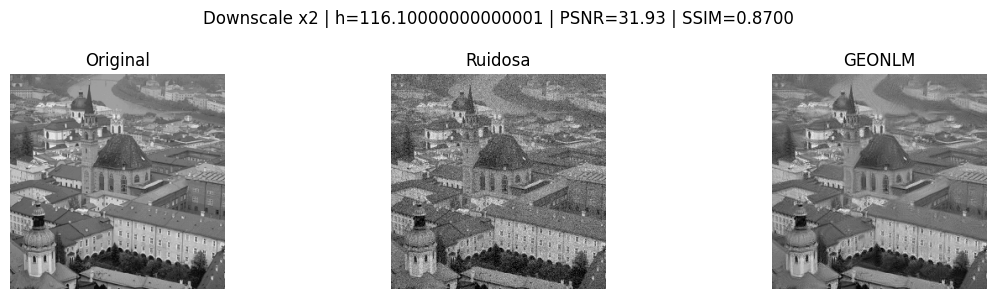

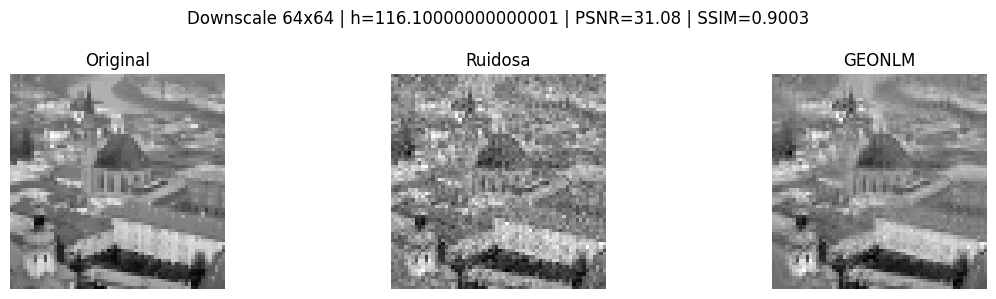

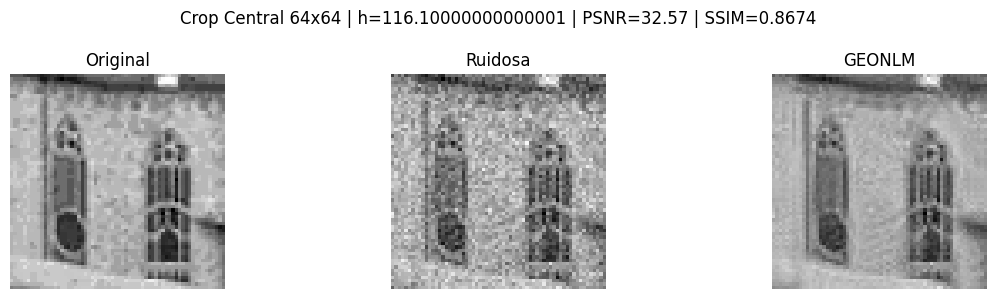

In [15]:
# ------------------------- EXEMPLO DE USO COM 3 ABORDAGENS -------------------------

# Parâmetros
f = 4
t = 7
nn = 10

# Carregamento
img_path = '../images/4.gif'
img = skimage.io.imread(img_path)
img = img[0, :, :] if len(img.shape) > 2 else img
if len(img.shape) > 2:
    img = skimage.color.rgb2gray(img)
    img = 255 * img
img = img.astype(np.float32)

# Abordagens
originals = {
    "Downscale x2": downscale_local_mean(img, (2, 2)).astype(np.float32),
    "Downscale 64x64": downscale_to_64(img),
    "Crop Central 64x64": crop_center(img, (64, 64))
}

results = {}

for label, img_variant in originals.items():
    print(f"\n--- Executando {label} ---")
    img_base, img_noisy, img_filtered, h_val, psnr_val, ssim_val = run_single_pipeline(img_variant, f, t, nn)
    results[label] = (img_base, img_noisy, img_filtered, h_val, psnr_val, ssim_val)

# ------------------------- VISUALIZAÇÃO -------------------------

import matplotlib.pyplot as plt

for label, (original, noisy, filtered, h, psnr, ssim) in results.items():
    plt.figure(figsize=(12, 3))
    plt.suptitle(f"{label} | h={h} | PSNR={psnr:.2f} | SSIM={ssim:.4f}")
    plt.subplot(1, 3, 1); plt.title("Original"); plt.imshow(original.astype(np.uint8), cmap='gray'); plt.axis('off')
    plt.subplot(1, 3, 2); plt.title("Ruidosa"); plt.imshow(noisy.astype(np.uint8), cmap='gray'); plt.axis('off')
    plt.subplot(1, 3, 3); plt.title("GEONLM"); plt.imshow(filtered.astype(np.uint8), cmap='gray'); plt.axis('off')
    plt.tight_layout()
    plt.show()


--- Executando Downscale x2 ---
q_nlm: 129, g_geo: 168

Executando GEONLM com h = 90.30 (base 129 * 0.7)
img_n.shape: (264, 264)
M: 256, N: 256
→ PSNR: 30.33, SSIM: 0.8806, Score: 59.19

Executando GEONLM com h = 103.20 (base 129 * 0.8)
img_n.shape: (264, 264)
M: 256, N: 256
→ PSNR: 31.32, SSIM: 0.9000, Score: 60.66

Executando GEONLM com h = 116.10 (base 129 * 0.9)
img_n.shape: (264, 264)
M: 256, N: 256
→ PSNR: 31.95, SSIM: 0.9084, Score: 61.39

Executando GEONLM com h = 141.90 (base 129 * 1.1)
img_n.shape: (264, 264)
M: 256, N: 256
→ PSNR: 31.98, SSIM: 0.9037, Score: 61.18

Executando GEONLM com h = 148.35 (base 129 * 1.15)
img_n.shape: (264, 264)
M: 256, N: 256
→ PSNR: 31.85, SSIM: 0.9001, Score: 60.93

Executando GEONLM com h = 154.80 (base 129 * 1.2)
img_n.shape: (264, 264)
M: 256, N: 256
→ PSNR: 31.68, SSIM: 0.8959, Score: 60.64

Executando GEONLM com h = 161.25 (base 129 * 1.25)
img_n.shape: (264, 264)
M: 256, N: 256
→ PSNR: 31.50, SSIM: 0.8915, Score: 60.32

Executando GEONLM 

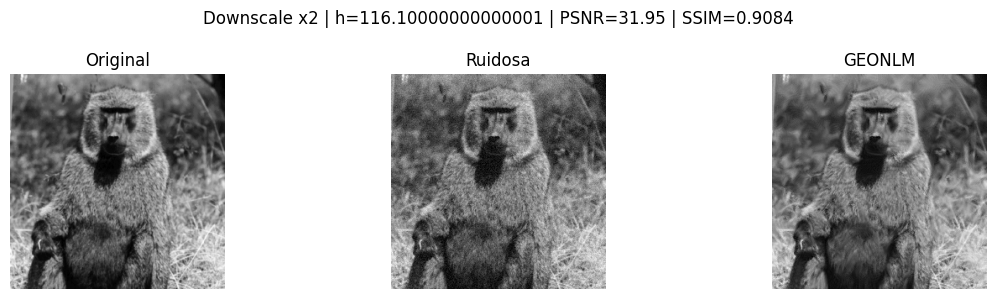

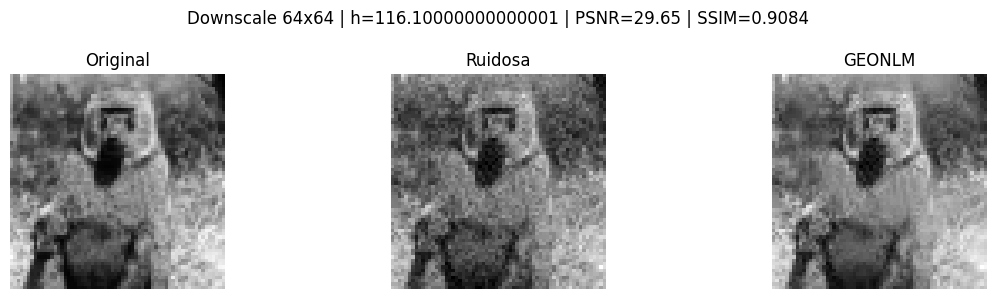

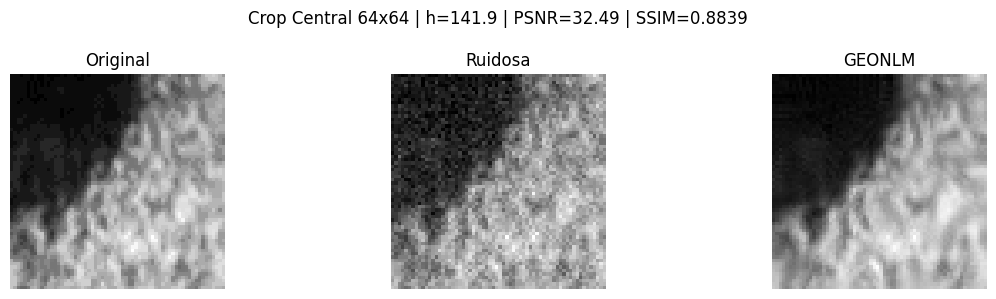

In [16]:
# ------------------------- EXEMPLO DE USO COM 3 ABORDAGENS -------------------------

# Parâmetros
f = 4
t = 7
nn = 10

# Carregamento
img_path = '../images/5.gif'
img = skimage.io.imread(img_path)
img = img[0, :, :] if len(img.shape) > 2 else img
if len(img.shape) > 2:
    img = skimage.color.rgb2gray(img)
    img = 255 * img
img = img.astype(np.float32)

# Abordagens
originals = {
    "Downscale x2": downscale_local_mean(img, (2, 2)).astype(np.float32),
    "Downscale 64x64": downscale_to_64(img),
    "Crop Central 64x64": crop_center(img, (64, 64))
}

results = {}

for label, img_variant in originals.items():
    print(f"\n--- Executando {label} ---")
    img_base, img_noisy, img_filtered, h_val, psnr_val, ssim_val = run_single_pipeline(img_variant, f, t, nn)
    results[label] = (img_base, img_noisy, img_filtered, h_val, psnr_val, ssim_val)

# ------------------------- VISUALIZAÇÃO -------------------------

import matplotlib.pyplot as plt

for label, (original, noisy, filtered, h, psnr, ssim) in results.items():
    plt.figure(figsize=(12, 3))
    plt.suptitle(f"{label} | h={h} | PSNR={psnr:.2f} | SSIM={ssim:.4f}")
    plt.subplot(1, 3, 1); plt.title("Original"); plt.imshow(original.astype(np.uint8), cmap='gray'); plt.axis('off')
    plt.subplot(1, 3, 2); plt.title("Ruidosa"); plt.imshow(noisy.astype(np.uint8), cmap='gray'); plt.axis('off')
    plt.subplot(1, 3, 3); plt.title("GEONLM"); plt.imshow(filtered.astype(np.uint8), cmap='gray'); plt.axis('off')
    plt.tight_layout()
    plt.show()


--- Executando Downscale x2 ---
q_nlm: 129, g_geo: 168

Executando GEONLM com h = 90.30 (base 129 * 0.7)
img_n.shape: (264, 264)
M: 256, N: 256
→ PSNR: 30.11, SSIM: 0.8611, Score: 58.11

Executando GEONLM com h = 103.20 (base 129 * 0.8)
img_n.shape: (264, 264)
M: 256, N: 256
→ PSNR: 30.68, SSIM: 0.8829, Score: 59.49

Executando GEONLM com h = 116.10 (base 129 * 0.9)
img_n.shape: (264, 264)
M: 256, N: 256
→ PSNR: 31.19, SSIM: 0.8983, Score: 60.51

Executando GEONLM com h = 141.90 (base 129 * 1.1)
img_n.shape: (264, 264)
M: 256, N: 256
→ PSNR: 31.42, SSIM: 0.9066, Score: 61.04

Executando GEONLM com h = 148.35 (base 129 * 1.15)
img_n.shape: (264, 264)
M: 256, N: 256
→ PSNR: 31.27, SSIM: 0.9046, Score: 60.87

Executando GEONLM com h = 154.80 (base 129 * 1.2)
img_n.shape: (264, 264)
M: 256, N: 256
→ PSNR: 31.07, SSIM: 0.9016, Score: 60.62

Executando GEONLM com h = 161.25 (base 129 * 1.25)
img_n.shape: (264, 264)
M: 256, N: 256
→ PSNR: 30.83, SSIM: 0.8973, Score: 60.28

Executando GEONLM 

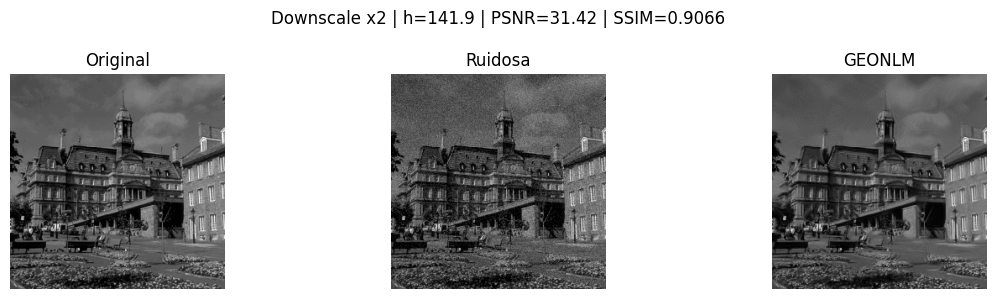

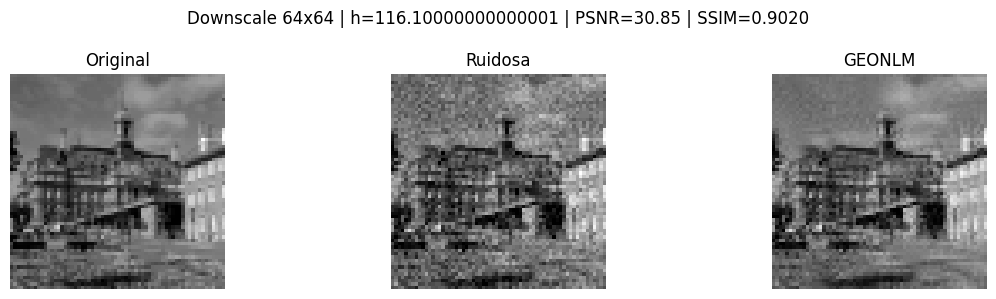

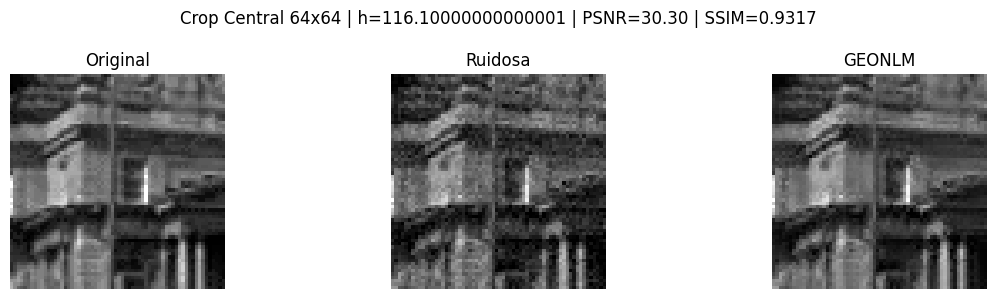

In [17]:
# ------------------------- EXEMPLO DE USO COM 3 ABORDAGENS -------------------------

# Parâmetros
f = 4
t = 7
nn = 10

# Carregamento
img_path = '../images/6.gif'
img = skimage.io.imread(img_path)
img = img[0, :, :] if len(img.shape) > 2 else img
if len(img.shape) > 2:
    img = skimage.color.rgb2gray(img)
    img = 255 * img
img = img.astype(np.float32)

# Abordagens
originals = {
    "Downscale x2": downscale_local_mean(img, (2, 2)).astype(np.float32),
    "Downscale 64x64": downscale_to_64(img),
    "Crop Central 64x64": crop_center(img, (64, 64))
}

results = {}

for label, img_variant in originals.items():
    print(f"\n--- Executando {label} ---")
    img_base, img_noisy, img_filtered, h_val, psnr_val, ssim_val = run_single_pipeline(img_variant, f, t, nn)
    results[label] = (img_base, img_noisy, img_filtered, h_val, psnr_val, ssim_val)

# ------------------------- VISUALIZAÇÃO -------------------------

import matplotlib.pyplot as plt

for label, (original, noisy, filtered, h, psnr, ssim) in results.items():
    plt.figure(figsize=(12, 3))
    plt.suptitle(f"{label} | h={h} | PSNR={psnr:.2f} | SSIM={ssim:.4f}")
    plt.subplot(1, 3, 1); plt.title("Original"); plt.imshow(original.astype(np.uint8), cmap='gray'); plt.axis('off')
    plt.subplot(1, 3, 2); plt.title("Ruidosa"); plt.imshow(noisy.astype(np.uint8), cmap='gray'); plt.axis('off')
    plt.subplot(1, 3, 3); plt.title("GEONLM"); plt.imshow(filtered.astype(np.uint8), cmap='gray'); plt.axis('off')
    plt.tight_layout()
    plt.show()


--- Executando Downscale x2 ---
q_nlm: 129, g_geo: 169

Executando GEONLM com h = 90.30 (base 129 * 0.7)
img_n.shape: (264, 264)
M: 256, N: 256
→ PSNR: 29.33, SSIM: 0.9149, Score: 60.41

Executando GEONLM com h = 103.20 (base 129 * 0.8)
img_n.shape: (264, 264)
M: 256, N: 256
→ PSNR: 29.84, SSIM: 0.9260, Score: 61.22

Executando GEONLM com h = 116.10 (base 129 * 0.9)
img_n.shape: (264, 264)
M: 256, N: 256
→ PSNR: 30.30, SSIM: 0.9334, Score: 61.82

Executando GEONLM com h = 141.90 (base 129 * 1.1)
img_n.shape: (264, 264)
M: 256, N: 256
→ PSNR: 30.80, SSIM: 0.9377, Score: 62.28

Executando GEONLM com h = 148.35 (base 129 * 1.15)
img_n.shape: (264, 264)
M: 256, N: 256
→ PSNR: 30.81, SSIM: 0.9370, Score: 62.26

Executando GEONLM com h = 154.80 (base 129 * 1.2)
img_n.shape: (264, 264)
M: 256, N: 256
→ PSNR: 30.78, SSIM: 0.9358, Score: 62.18

Executando GEONLM com h = 161.25 (base 129 * 1.25)
img_n.shape: (264, 264)
M: 256, N: 256
→ PSNR: 30.71, SSIM: 0.9341, Score: 62.06

Executando GEONLM 

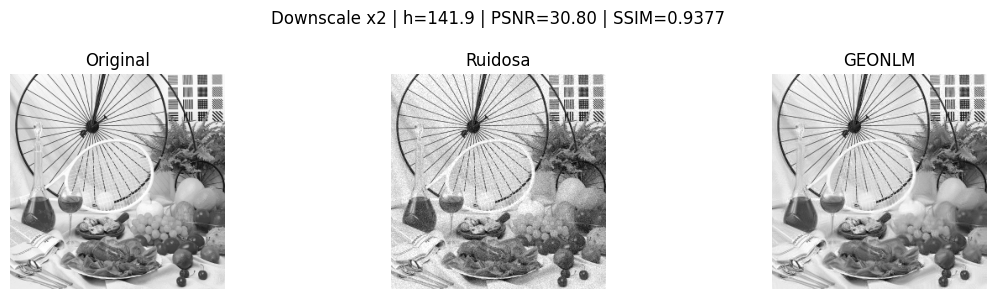

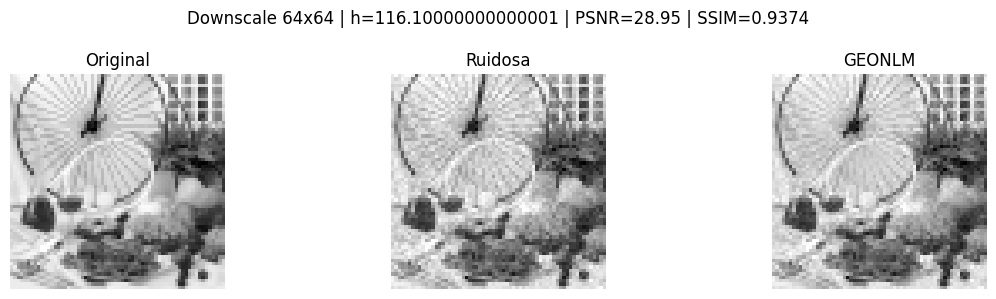

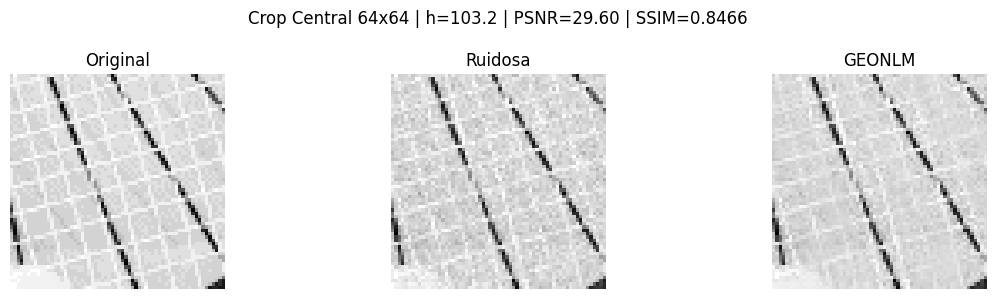

In [18]:
# ------------------------- EXEMPLO DE USO COM 3 ABORDAGENS -------------------------

# Parâmetros
f = 4
t = 7
nn = 10

# Carregamento
img_path = '../images/7.gif'
img = skimage.io.imread(img_path)
img = img[0, :, :] if len(img.shape) > 2 else img
if len(img.shape) > 2:
    img = skimage.color.rgb2gray(img)
    img = 255 * img
img = img.astype(np.float32)

# Abordagens
originals = {
    "Downscale x2": downscale_local_mean(img, (2, 2)).astype(np.float32),
    "Downscale 64x64": downscale_to_64(img),
    "Crop Central 64x64": crop_center(img, (64, 64))
}

results = {}

for label, img_variant in originals.items():
    print(f"\n--- Executando {label} ---")
    img_base, img_noisy, img_filtered, h_val, psnr_val, ssim_val = run_single_pipeline(img_variant, f, t, nn)
    results[label] = (img_base, img_noisy, img_filtered, h_val, psnr_val, ssim_val)

# ------------------------- VISUALIZAÇÃO -------------------------

import matplotlib.pyplot as plt

for label, (original, noisy, filtered, h, psnr, ssim) in results.items():
    plt.figure(figsize=(12, 3))
    plt.suptitle(f"{label} | h={h} | PSNR={psnr:.2f} | SSIM={ssim:.4f}")
    plt.subplot(1, 3, 1); plt.title("Original"); plt.imshow(original.astype(np.uint8), cmap='gray'); plt.axis('off')
    plt.subplot(1, 3, 2); plt.title("Ruidosa"); plt.imshow(noisy.astype(np.uint8), cmap='gray'); plt.axis('off')
    plt.subplot(1, 3, 3); plt.title("GEONLM"); plt.imshow(filtered.astype(np.uint8), cmap='gray'); plt.axis('off')
    plt.tight_layout()
    plt.show()


--- Executando Downscale x2 ---
q_nlm: 129, g_geo: 168

Executando GEONLM com h = 90.30 (base 129 * 0.7)
img_n.shape: (264, 264)
M: 256, N: 256
→ PSNR: 30.95, SSIM: 0.8486, Score: 57.91

Executando GEONLM com h = 103.20 (base 129 * 0.8)
img_n.shape: (264, 264)
M: 256, N: 256
→ PSNR: 31.74, SSIM: 0.8761, Score: 59.67

Executando GEONLM com h = 116.10 (base 129 * 0.9)
img_n.shape: (264, 264)
M: 256, N: 256
→ PSNR: 32.23, SSIM: 0.8912, Score: 60.67

Executando GEONLM com h = 141.90 (base 129 * 1.1)
img_n.shape: (264, 264)
M: 256, N: 256
→ PSNR: 32.25, SSIM: 0.8933, Score: 60.79

Executando GEONLM com h = 148.35 (base 129 * 1.15)
img_n.shape: (264, 264)
M: 256, N: 256
→ PSNR: 32.12, SSIM: 0.8906, Score: 60.59

Executando GEONLM com h = 154.80 (base 129 * 1.2)
img_n.shape: (264, 264)
M: 256, N: 256
→ PSNR: 31.97, SSIM: 0.8871, Score: 60.34

Executando GEONLM com h = 161.25 (base 129 * 1.25)
img_n.shape: (264, 264)
M: 256, N: 256
→ PSNR: 31.81, SSIM: 0.8831, Score: 60.06

Executando GEONLM 

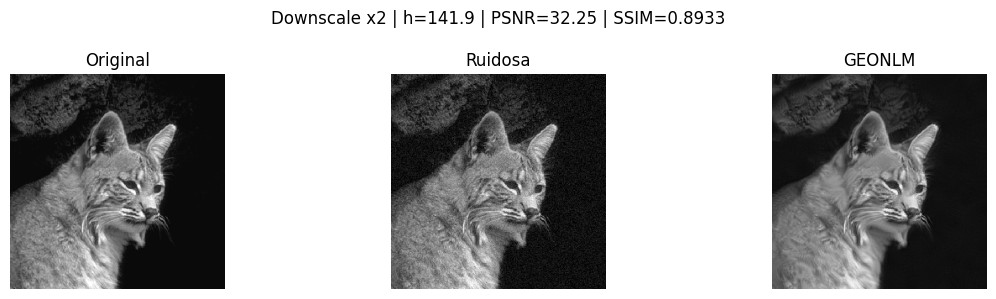

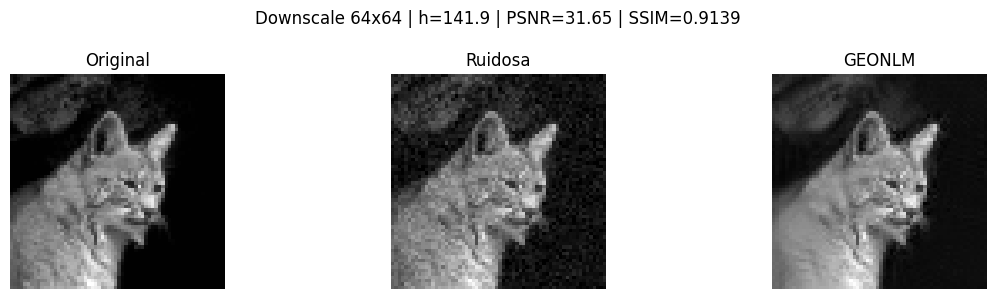

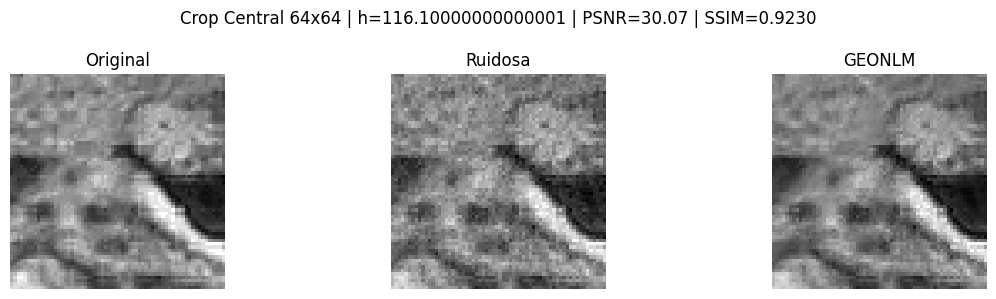

In [19]:
# ------------------------- EXEMPLO DE USO COM 3 ABORDAGENS -------------------------

# Parâmetros
f = 4
t = 7
nn = 10

# Carregamento
img_path = '../images/8.gif'
img = skimage.io.imread(img_path)
img = img[0, :, :] if len(img.shape) > 2 else img
if len(img.shape) > 2:
    img = skimage.color.rgb2gray(img)
    img = 255 * img
img = img.astype(np.float32)

# Abordagens
originals = {
    "Downscale x2": downscale_local_mean(img, (2, 2)).astype(np.float32),
    "Downscale 64x64": downscale_to_64(img),
    "Crop Central 64x64": crop_center(img, (64, 64))
}

results = {}

for label, img_variant in originals.items():
    print(f"\n--- Executando {label} ---")
    img_base, img_noisy, img_filtered, h_val, psnr_val, ssim_val = run_single_pipeline(img_variant, f, t, nn)
    results[label] = (img_base, img_noisy, img_filtered, h_val, psnr_val, ssim_val)

# ------------------------- VISUALIZAÇÃO -------------------------

import matplotlib.pyplot as plt

for label, (original, noisy, filtered, h, psnr, ssim) in results.items():
    plt.figure(figsize=(12, 3))
    plt.suptitle(f"{label} | h={h} | PSNR={psnr:.2f} | SSIM={ssim:.4f}")
    plt.subplot(1, 3, 1); plt.title("Original"); plt.imshow(original.astype(np.uint8), cmap='gray'); plt.axis('off')
    plt.subplot(1, 3, 2); plt.title("Ruidosa"); plt.imshow(noisy.astype(np.uint8), cmap='gray'); plt.axis('off')
    plt.subplot(1, 3, 3); plt.title("GEONLM"); plt.imshow(filtered.astype(np.uint8), cmap='gray'); plt.axis('off')
    plt.tight_layout()
    plt.show()


--- Executando Downscale x2 ---
q_nlm: 129, g_geo: 169

Executando GEONLM com h = 90.30 (base 129 * 0.7)
img_n.shape: (264, 264)
M: 256, N: 256
→ PSNR: 30.16, SSIM: 0.8719, Score: 58.68

Executando GEONLM com h = 103.20 (base 129 * 0.8)
img_n.shape: (264, 264)
M: 256, N: 256
→ PSNR: 30.79, SSIM: 0.8954, Score: 60.16

Executando GEONLM com h = 116.10 (base 129 * 0.9)
img_n.shape: (264, 264)
M: 256, N: 256
→ PSNR: 31.27, SSIM: 0.9106, Score: 61.16

Executando GEONLM com h = 141.90 (base 129 * 1.1)
img_n.shape: (264, 264)
M: 256, N: 256
→ PSNR: 31.57, SSIM: 0.9190, Score: 61.74

Executando GEONLM com h = 148.35 (base 129 * 1.15)
img_n.shape: (264, 264)
M: 256, N: 256
→ PSNR: 31.49, SSIM: 0.9179, Score: 61.64

Executando GEONLM com h = 154.80 (base 129 * 1.2)
img_n.shape: (264, 264)
M: 256, N: 256
→ PSNR: 31.37, SSIM: 0.9159, Score: 61.48

Executando GEONLM com h = 161.25 (base 129 * 1.25)
img_n.shape: (264, 264)
M: 256, N: 256
→ PSNR: 31.20, SSIM: 0.9133, Score: 61.26

Executando GEONLM 

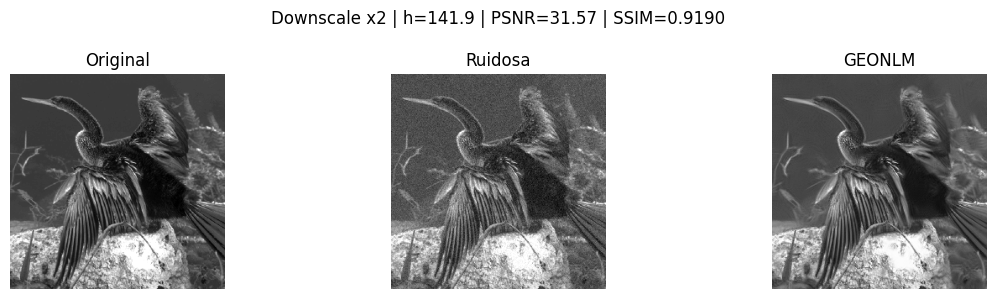

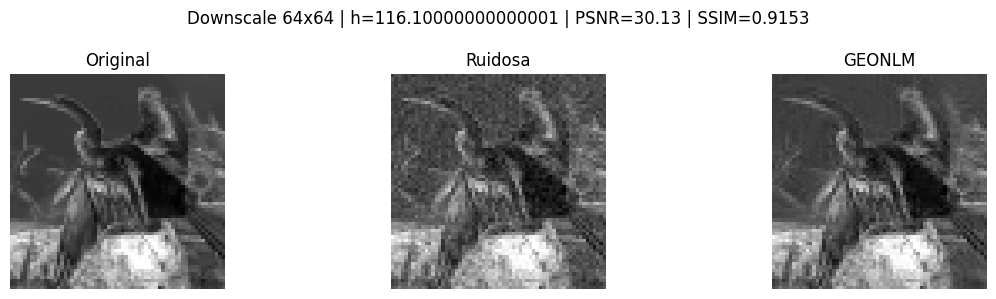

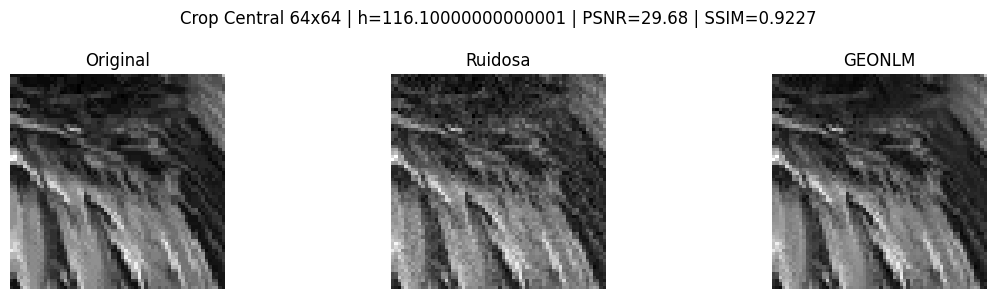

In [20]:
# ------------------------- EXEMPLO DE USO COM 3 ABORDAGENS -------------------------

# Parâmetros
f = 4
t = 7
nn = 10

# Carregamento
img_path = '../images/9.gif'
img = skimage.io.imread(img_path)
img = img[0, :, :] if len(img.shape) > 2 else img
if len(img.shape) > 2:
    img = skimage.color.rgb2gray(img)
    img = 255 * img
img = img.astype(np.float32)

# Abordagens
originals = {
    "Downscale x2": downscale_local_mean(img, (2, 2)).astype(np.float32),
    "Downscale 64x64": downscale_to_64(img),
    "Crop Central 64x64": crop_center(img, (64, 64))
}

results = {}

for label, img_variant in originals.items():
    print(f"\n--- Executando {label} ---")
    img_base, img_noisy, img_filtered, h_val, psnr_val, ssim_val = run_single_pipeline(img_variant, f, t, nn)
    results[label] = (img_base, img_noisy, img_filtered, h_val, psnr_val, ssim_val)

# ------------------------- VISUALIZAÇÃO -------------------------

import matplotlib.pyplot as plt

for label, (original, noisy, filtered, h, psnr, ssim) in results.items():
    plt.figure(figsize=(12, 3))
    plt.suptitle(f"{label} | h={h} | PSNR={psnr:.2f} | SSIM={ssim:.4f}")
    plt.subplot(1, 3, 1); plt.title("Original"); plt.imshow(original.astype(np.uint8), cmap='gray'); plt.axis('off')
    plt.subplot(1, 3, 2); plt.title("Ruidosa"); plt.imshow(noisy.astype(np.uint8), cmap='gray'); plt.axis('off')
    plt.subplot(1, 3, 3); plt.title("GEONLM"); plt.imshow(filtered.astype(np.uint8), cmap='gray'); plt.axis('off')
    plt.tight_layout()
    plt.show()


--- Executando Downscale x2 ---
q_nlm: 129, g_geo: 168

Executando GEONLM com h = 90.30 (base 129 * 0.7)
img_n.shape: (264, 264)
M: 256, N: 256
→ PSNR: 31.13, SSIM: 0.8407, Score: 57.60

Executando GEONLM com h = 103.20 (base 129 * 0.8)
img_n.shape: (264, 264)
M: 256, N: 256
→ PSNR: 31.85, SSIM: 0.8719, Score: 59.52

Executando GEONLM com h = 116.10 (base 129 * 0.9)
img_n.shape: (264, 264)
M: 256, N: 256
→ PSNR: 32.44, SSIM: 0.8936, Score: 60.90

Executando GEONLM com h = 141.90 (base 129 * 1.1)
img_n.shape: (264, 264)
M: 256, N: 256
→ PSNR: 33.07, SSIM: 0.9142, Score: 62.24

Executando GEONLM com h = 148.35 (base 129 * 1.15)
img_n.shape: (264, 264)
M: 256, N: 256
→ PSNR: 33.10, SSIM: 0.9159, Score: 62.34

Executando GEONLM com h = 154.80 (base 129 * 1.2)
img_n.shape: (264, 264)
M: 256, N: 256
→ PSNR: 33.07, SSIM: 0.9167, Score: 62.37

Executando GEONLM com h = 161.25 (base 129 * 1.25)
img_n.shape: (264, 264)
M: 256, N: 256
→ PSNR: 33.00, SSIM: 0.9168, Score: 62.34

Executando GEONLM 

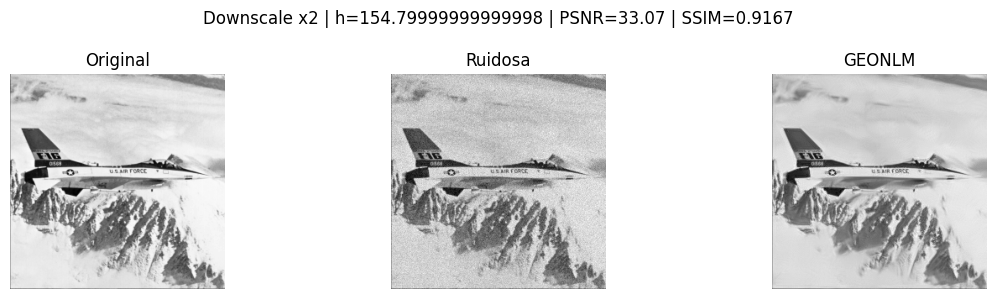

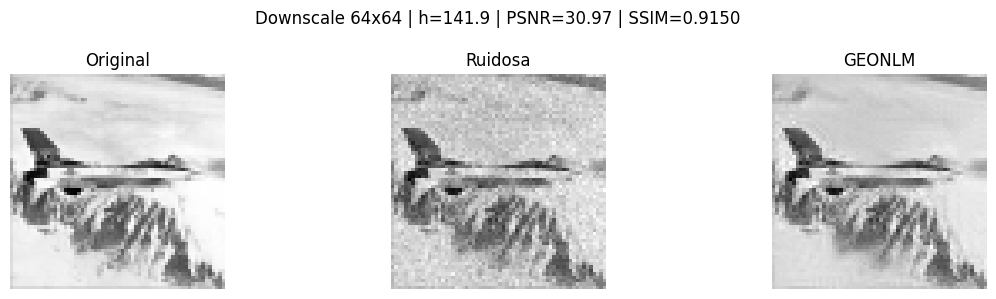

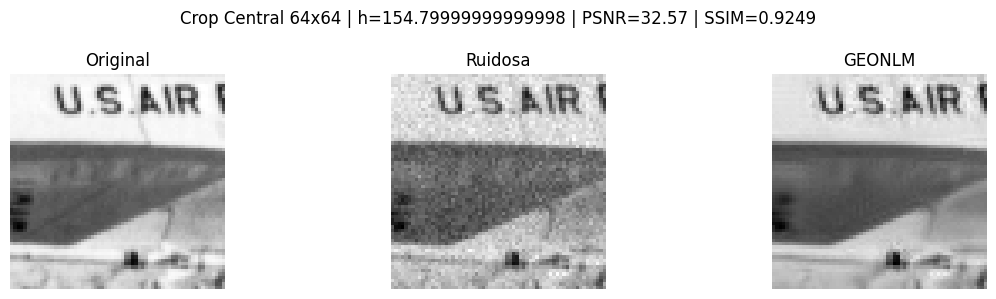

In [21]:
# ------------------------- EXEMPLO DE USO COM 3 ABORDAGENS -------------------------

# Parâmetros
f = 4
t = 7
nn = 10

# Carregamento
img_path = '../images/10.gif'
img = skimage.io.imread(img_path)
img = img[0, :, :] if len(img.shape) > 2 else img
if len(img.shape) > 2:
    img = skimage.color.rgb2gray(img)
    img = 255 * img
img = img.astype(np.float32)

# Abordagens
originals = {
    "Downscale x2": downscale_local_mean(img, (2, 2)).astype(np.float32),
    "Downscale 64x64": downscale_to_64(img),
    "Crop Central 64x64": crop_center(img, (64, 64))
}

results = {}

for label, img_variant in originals.items():
    print(f"\n--- Executando {label} ---")
    img_base, img_noisy, img_filtered, h_val, psnr_val, ssim_val = run_single_pipeline(img_variant, f, t, nn)
    results[label] = (img_base, img_noisy, img_filtered, h_val, psnr_val, ssim_val)

# ------------------------- VISUALIZAÇÃO -------------------------

import matplotlib.pyplot as plt

for label, (original, noisy, filtered, h, psnr, ssim) in results.items():
    plt.figure(figsize=(12, 3))
    plt.suptitle(f"{label} | h={h} | PSNR={psnr:.2f} | SSIM={ssim:.4f}")
    plt.subplot(1, 3, 1); plt.title("Original"); plt.imshow(original.astype(np.uint8), cmap='gray'); plt.axis('off')
    plt.subplot(1, 3, 2); plt.title("Ruidosa"); plt.imshow(noisy.astype(np.uint8), cmap='gray'); plt.axis('off')
    plt.subplot(1, 3, 3); plt.title("GEONLM"); plt.imshow(filtered.astype(np.uint8), cmap='gray'); plt.axis('off')
    plt.tight_layout()
    plt.show()


--- Executando Downscale x2 ---
q_nlm: 129, g_geo: 169

Executando GEONLM com h = 90.30 (base 129 * 0.7)
img_n.shape: (264, 264)
M: 256, N: 256
→ PSNR: 30.16, SSIM: 0.9230, Score: 61.23

Executando GEONLM com h = 103.20 (base 129 * 0.8)
img_n.shape: (264, 264)
M: 256, N: 256
→ PSNR: 30.64, SSIM: 0.9339, Score: 62.01

Executando GEONLM com h = 116.10 (base 129 * 0.9)
img_n.shape: (264, 264)
M: 256, N: 256
→ PSNR: 31.06, SSIM: 0.9410, Score: 62.58

Executando GEONLM com h = 141.90 (base 129 * 1.1)
img_n.shape: (264, 264)
M: 256, N: 256
→ PSNR: 31.55, SSIM: 0.9467, Score: 63.11

Executando GEONLM com h = 148.35 (base 129 * 1.15)
img_n.shape: (264, 264)
M: 256, N: 256
→ PSNR: 31.58, SSIM: 0.9466, Score: 63.12

Executando GEONLM com h = 154.80 (base 129 * 1.2)
img_n.shape: (264, 264)
M: 256, N: 256
→ PSNR: 31.58, SSIM: 0.9463, Score: 63.11

Executando GEONLM com h = 161.25 (base 129 * 1.25)
img_n.shape: (264, 264)
M: 256, N: 256
→ PSNR: 31.55, SSIM: 0.9455, Score: 63.05

Executando GEONLM 

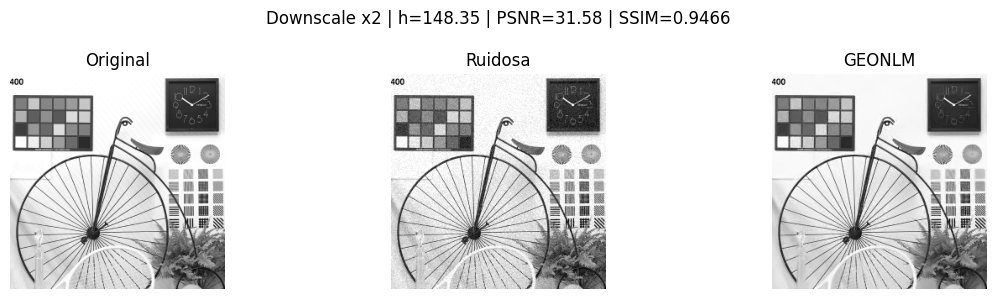

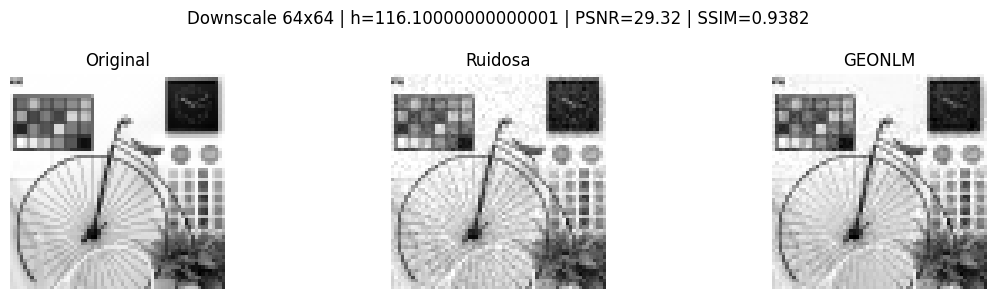

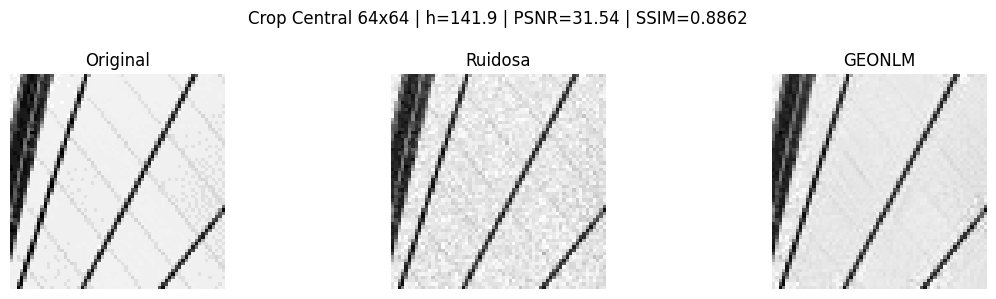

In [22]:
# ------------------------- EXEMPLO DE USO COM 3 ABORDAGENS -------------------------

# Parâmetros
f = 4
t = 7
nn = 10

# Carregamento
img_path = '../images/11.gif'
img = skimage.io.imread(img_path)
img = img[0, :, :] if len(img.shape) > 2 else img
if len(img.shape) > 2:
    img = skimage.color.rgb2gray(img)
    img = 255 * img
img = img.astype(np.float32)

# Abordagens
originals = {
    "Downscale x2": downscale_local_mean(img, (2, 2)).astype(np.float32),
    "Downscale 64x64": downscale_to_64(img),
    "Crop Central 64x64": crop_center(img, (64, 64))
}

results = {}

for label, img_variant in originals.items():
    print(f"\n--- Executando {label} ---")
    img_base, img_noisy, img_filtered, h_val, psnr_val, ssim_val = run_single_pipeline(img_variant, f, t, nn)
    results[label] = (img_base, img_noisy, img_filtered, h_val, psnr_val, ssim_val)

# ------------------------- VISUALIZAÇÃO -------------------------

import matplotlib.pyplot as plt

for label, (original, noisy, filtered, h, psnr, ssim) in results.items():
    plt.figure(figsize=(12, 3))
    plt.suptitle(f"{label} | h={h} | PSNR={psnr:.2f} | SSIM={ssim:.4f}")
    plt.subplot(1, 3, 1); plt.title("Original"); plt.imshow(original.astype(np.uint8), cmap='gray'); plt.axis('off')
    plt.subplot(1, 3, 2); plt.title("Ruidosa"); plt.imshow(noisy.astype(np.uint8), cmap='gray'); plt.axis('off')
    plt.subplot(1, 3, 3); plt.title("GEONLM"); plt.imshow(filtered.astype(np.uint8), cmap='gray'); plt.axis('off')
    plt.tight_layout()
    plt.show()


--- Executando Downscale x2 ---
q_nlm: 129, g_geo: 168

Executando GEONLM com h = 90.30 (base 129 * 0.7)
img_n.shape: (264, 264)
M: 256, N: 256
→ PSNR: 30.51, SSIM: 0.8713, Score: 58.82

Executando GEONLM com h = 103.20 (base 129 * 0.8)
img_n.shape: (264, 264)
M: 256, N: 256
→ PSNR: 31.08, SSIM: 0.8829, Score: 59.68

Executando GEONLM com h = 116.10 (base 129 * 0.9)
img_n.shape: (264, 264)
M: 256, N: 256
→ PSNR: 31.45, SSIM: 0.8872, Score: 60.09

Executando GEONLM com h = 141.90 (base 129 * 1.1)
img_n.shape: (264, 264)
M: 256, N: 256
→ PSNR: 31.59, SSIM: 0.8823, Score: 59.91

Executando GEONLM com h = 148.35 (base 129 * 1.15)
img_n.shape: (264, 264)
M: 256, N: 256
→ PSNR: 31.51, SSIM: 0.8794, Score: 59.72

Executando GEONLM com h = 154.80 (base 129 * 1.2)
img_n.shape: (264, 264)
M: 256, N: 256
→ PSNR: 31.40, SSIM: 0.8758, Score: 59.49

Executando GEONLM com h = 161.25 (base 129 * 1.25)
img_n.shape: (264, 264)
M: 256, N: 256
→ PSNR: 31.26, SSIM: 0.8721, Score: 59.23

Executando GEONLM 

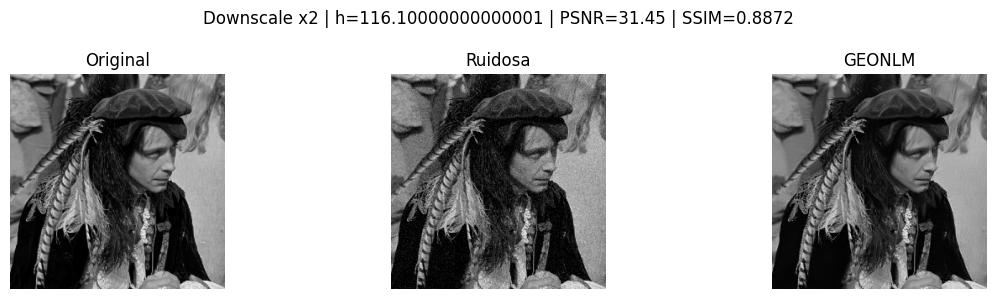

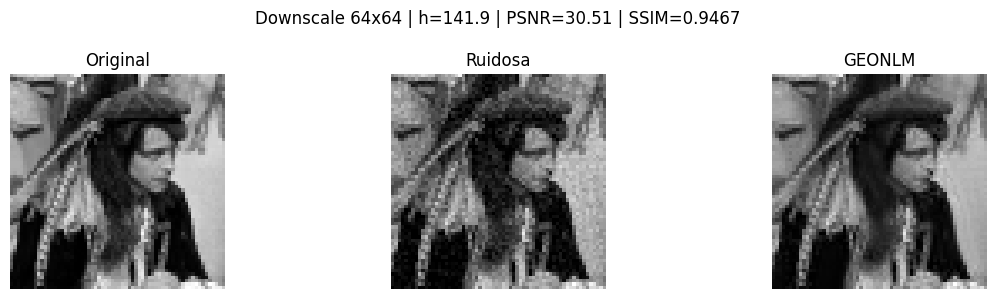

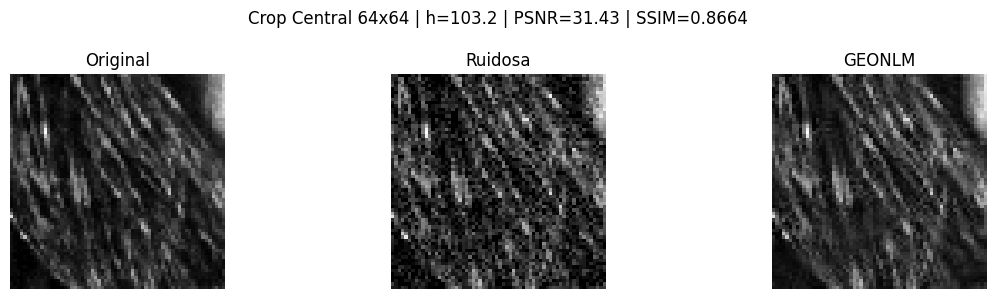

In [23]:
# ------------------------- EXEMPLO DE USO COM 3 ABORDAGENS -------------------------

# Parâmetros
f = 4
t = 7
nn = 10

# Carregamento
img_path = '../images/12.gif'
img = skimage.io.imread(img_path)
img = img[0, :, :] if len(img.shape) > 2 else img
if len(img.shape) > 2:
    img = skimage.color.rgb2gray(img)
    img = 255 * img
img = img.astype(np.float32)

# Abordagens
originals = {
    "Downscale x2": downscale_local_mean(img, (2, 2)).astype(np.float32),
    "Downscale 64x64": downscale_to_64(img),
    "Crop Central 64x64": crop_center(img, (64, 64))
}

results = {}

for label, img_variant in originals.items():
    print(f"\n--- Executando {label} ---")
    img_base, img_noisy, img_filtered, h_val, psnr_val, ssim_val = run_single_pipeline(img_variant, f, t, nn)
    results[label] = (img_base, img_noisy, img_filtered, h_val, psnr_val, ssim_val)

# ------------------------- VISUALIZAÇÃO -------------------------

import matplotlib.pyplot as plt

for label, (original, noisy, filtered, h, psnr, ssim) in results.items():
    plt.figure(figsize=(12, 3))
    plt.suptitle(f"{label} | h={h} | PSNR={psnr:.2f} | SSIM={ssim:.4f}")
    plt.subplot(1, 3, 1); plt.title("Original"); plt.imshow(original.astype(np.uint8), cmap='gray'); plt.axis('off')
    plt.subplot(1, 3, 2); plt.title("Ruidosa"); plt.imshow(noisy.astype(np.uint8), cmap='gray'); plt.axis('off')
    plt.subplot(1, 3, 3); plt.title("GEONLM"); plt.imshow(filtered.astype(np.uint8), cmap='gray'); plt.axis('off')
    plt.tight_layout()
    plt.show()


--- Executando Downscale 64x64 ---
q_nlm: 123, g_geo: 152

Executando GEONLM com h = 86.10 (base 123 * 0.7)
img_n.shape: (72, 72)
M: 64, N: 64
→ PSNR: 22.77, SSIM: 0.8202, Score: 52.40

Executando GEONLM com h = 98.40 (base 123 * 0.8)
img_n.shape: (72, 72)
M: 64, N: 64
→ PSNR: 22.87, SSIM: 0.8225, Score: 52.56

Executando GEONLM com h = 110.70 (base 123 * 0.9)
img_n.shape: (72, 72)
M: 64, N: 64
→ PSNR: 23.00, SSIM: 0.8265, Score: 52.83

Executando GEONLM com h = 135.30 (base 123 * 1.1)
img_n.shape: (72, 72)
M: 64, N: 64
→ PSNR: 23.39, SSIM: 0.8384, Score: 53.61

Executando GEONLM com h = 141.45 (base 123 * 1.15)
img_n.shape: (72, 72)
M: 64, N: 64
→ PSNR: 23.50, SSIM: 0.8417, Score: 53.84

Executando GEONLM com h = 147.60 (base 123 * 1.2)
img_n.shape: (72, 72)
M: 64, N: 64
→ PSNR: 23.63, SSIM: 0.8452, Score: 54.07

Executando GEONLM com h = 153.75 (base 123 * 1.25)
img_n.shape: (72, 72)
M: 64, N: 64
→ PSNR: 23.75, SSIM: 0.8482, Score: 54.29

Executando GEONLM com h = 159.90 (base 123 *

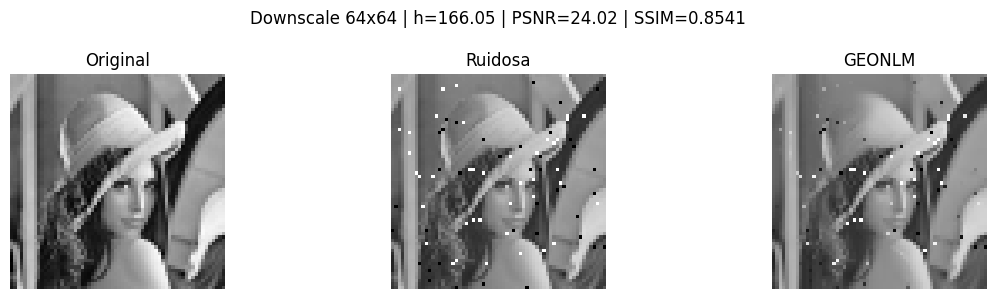

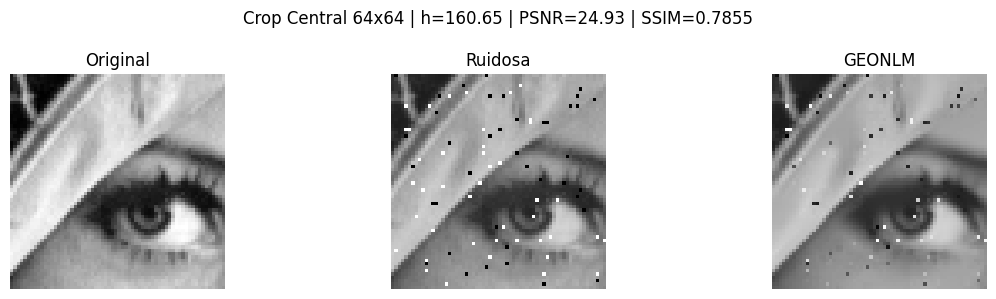

In [5]:
# ------------------------- EXEMPLO DE USO COM 3 ABORDAGENS -------------------------

# Parâmetros
f = 4
t = 7
nn = 10

# Carregamento
img_path = '../images/0.gif'
img = skimage.io.imread(img_path)
img = img[0, :, :] if len(img.shape) > 2 else img
if len(img.shape) > 2:
    img = skimage.color.rgb2gray(img)
    img = 255 * img
img = img.astype(np.float32)

# Abordagens
originals = {
    #"Downscale x2": downscale_local_mean(img, (2, 2)).astype(np.float32),
    "Downscale 64x64": downscale_to_64(img),
    "Crop Central 64x64": crop_center(img, (64, 64))
}

results = {}

for label, img_variant in originals.items():
    print(f"\n--- Executando {label} ---")
    img_base, img_noisy, img_filtered, h_val, psnr_val, ssim_val = run_single_pipeline(img_variant, f, t, nn)
    results[label] = (img_base, img_noisy, img_filtered, h_val, psnr_val, ssim_val)

# ------------------------- VISUALIZAÇÃO -------------------------

import matplotlib.pyplot as plt

for label, (original, noisy, filtered, h, psnr, ssim) in results.items():
    plt.figure(figsize=(12, 3))
    plt.suptitle(f"{label} | h={h} | PSNR={psnr:.2f} | SSIM={ssim:.4f}")
    plt.subplot(1, 3, 1); plt.title("Original"); plt.imshow(original.astype(np.uint8), cmap='gray'); plt.axis('off')
    plt.subplot(1, 3, 2); plt.title("Ruidosa"); plt.imshow(noisy.astype(np.uint8), cmap='gray'); plt.axis('off')
    plt.subplot(1, 3, 3); plt.title("GEONLM"); plt.imshow(filtered.astype(np.uint8), cmap='gray'); plt.axis('off')
    plt.tight_layout()
    plt.show()


--- Executando Downscale x2 ---
q_nlm: 112, g_geo: 133

Executando GEONLM com h = 78.40 (base 112 * 0.7)
img_n.shape: (136, 136)
M: 128, N: 128
→ PSNR: 22.29, SSIM: 0.7099, Score: 46.64

Executando GEONLM com h = 89.60 (base 112 * 0.8)
img_n.shape: (136, 136)
M: 128, N: 128
→ PSNR: 22.37, SSIM: 0.7138, Score: 46.87

Executando GEONLM com h = 100.80 (base 112 * 0.9)
img_n.shape: (136, 136)
M: 128, N: 128
→ PSNR: 22.50, SSIM: 0.7194, Score: 47.22

Executando GEONLM com h = 123.20 (base 112 * 1.1)
img_n.shape: (136, 136)
M: 128, N: 128
→ PSNR: 22.98, SSIM: 0.7364, Score: 48.31

Executando GEONLM com h = 128.80 (base 112 * 1.15)
img_n.shape: (136, 136)
M: 128, N: 128
→ PSNR: 23.15, SSIM: 0.7416, Score: 48.66

Executando GEONLM com h = 134.40 (base 112 * 1.2)
img_n.shape: (136, 136)
M: 128, N: 128
→ PSNR: 23.33, SSIM: 0.7470, Score: 49.02

Executando GEONLM com h = 140.00 (base 112 * 1.25)
img_n.shape: (136, 136)
M: 128, N: 128
→ PSNR: 23.53, SSIM: 0.7525, Score: 49.39

Executando GEONLM c

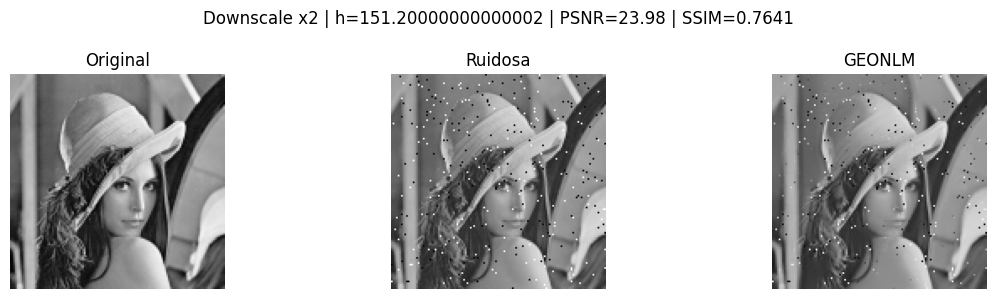

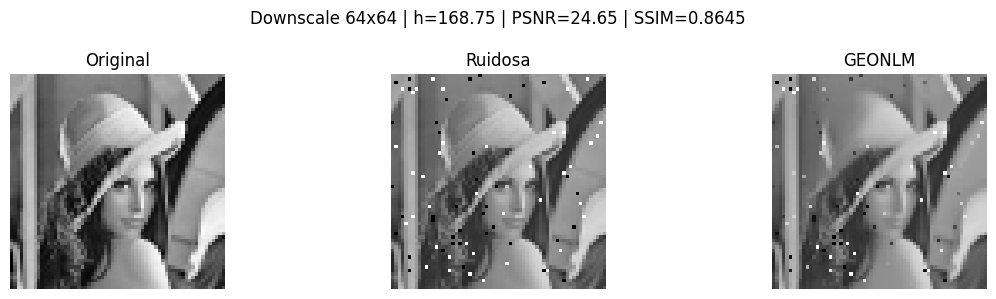

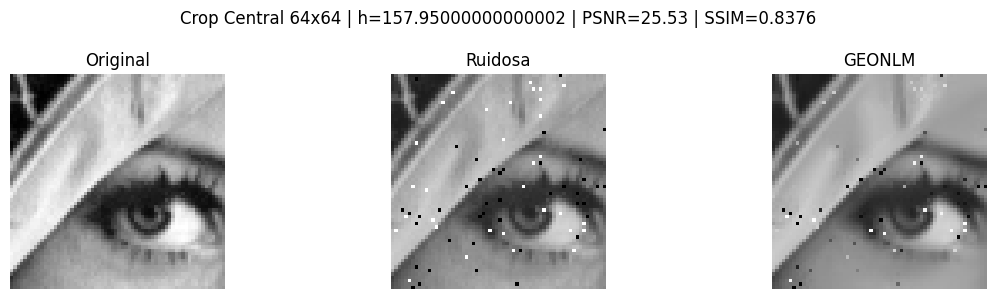

In [6]:
# ------------------------- EXEMPLO DE USO COM 3 ABORDAGENS -------------------------

# Parâmetros
f = 4
t = 7
nn = 10

# Carregamento
img_path = '../images/0.gif'
img = skimage.io.imread(img_path)
img = img[0, :, :] if len(img.shape) > 2 else img
if len(img.shape) > 2:
    img = skimage.color.rgb2gray(img)
    img = 255 * img
img = img.astype(np.float32)

# Abordagens
originals = {
    "Downscale x2": downscale_local_mean(img, (4, 4)).astype(np.float32),
    "Downscale 64x64": downscale_to_64(img),
    "Crop Central 64x64": crop_center(img, (64, 64))
}

results = {}

for label, img_variant in originals.items():
    print(f"\n--- Executando {label} ---")
    img_base, img_noisy, img_filtered, h_val, psnr_val, ssim_val = run_single_pipeline(img_variant, f, t, nn)
    results[label] = (img_base, img_noisy, img_filtered, h_val, psnr_val, ssim_val)

# ------------------------- VISUALIZAÇÃO -------------------------

import matplotlib.pyplot as plt

for label, (original, noisy, filtered, h, psnr, ssim) in results.items():
    plt.figure(figsize=(12, 3))
    plt.suptitle(f"{label} | h={h} | PSNR={psnr:.2f} | SSIM={ssim:.4f}")
    plt.subplot(1, 3, 1); plt.title("Original"); plt.imshow(original.astype(np.uint8), cmap='gray'); plt.axis('off')
    plt.subplot(1, 3, 2); plt.title("Ruidosa"); plt.imshow(noisy.astype(np.uint8), cmap='gray'); plt.axis('off')
    plt.subplot(1, 3, 3); plt.title("GEONLM"); plt.imshow(filtered.astype(np.uint8), cmap='gray'); plt.axis('off')
    plt.tight_layout()
    plt.show()